# Using EOF analysis for noise reduction in your data
[![Latest release](https://badgen.net/github/release/Naereen/Strapdown.js)](https://github.com/eabarnes1010/course_objective_analysis/tree/main/code)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/eabarnes1010/course_ml_ats/blob/main/code/unsupervised_eof_noise_reduction.ipynb)


Demonstration of how to use EOF analysis to remove "noise" from your data set.

In [ ]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
print('IN_COLAB = ' + str(IN_COLAB))


IN_COLAB = True


In [ ]:
if IN_COLAB:
    !apt-get install libproj-dev proj-data proj-bin
    !apt-get install libgeos-dev
    !pip install cython
    !pip install cartopy
    !apt-get -qq install python-cartopy python3-cartopy
    !pip uninstall -y shapely    
    !pip install shapely --no-binary shapely  

    !pip install netcdf4 #Package for loading in netcdf4 files
    !pip install cmocean #Package with beautiful colormaps

import numpy as np
import matplotlib.pyplot as plt
import importlib
import scipy.stats as stats
import numpy.ma as ma
import numpy.linalg as LA
import matplotlib as mpl
import xarray as xr
import scipy

import cartopy as ct
import cartopy.crs as ccrs
import cmocean as cmocean

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libproj-dev is already the newest version (4.9.3-2).
libproj-dev set to manually installed.
proj-data is already the newest version (4.9.3-2).
proj-data set to manually installed.
The following NEW packages will be installed:
  proj-bin
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 32.3 kB of archives.
After this operation, 110 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 proj-bin amd64 4.9.3-2 [32.3 kB]
Fetched 32.3 kB in 1s (59.4 kB/s)
Selecting previously unselected package proj-bin.
(Reading database ... 156210 files and directories currently installed.)
Preparing to unpack .../proj-bin_4.9.3-2_amd64.deb ...
Unpacking proj-bin (4.9.3-2) ...
Setting up proj-bin (4.9.3-2) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Reading package lists... Done
Building dependency tree       
Reading state

In [ ]:
mpl.rcParams['figure.dpi'] = 100
CL = 0.
mapProj = ct.crs.Robinson(central_longitude = CL)

### Globe plotting functions

In [ ]:
def drawOnGlobe(ax, data, lats, lons, cmap='coolwarm', vmin=None, vmax=None, inc=None, cbarBool=True, contourMap=[], contourVals = [], fastBool=False, extent='both'):

    data_crs = ct.crs.PlateCarree()
    data_cyc, lons_cyc = add_cyclic_point(data, coord=lons) #fixes white line by adding point#data,lons#ct.util.add_cyclic_point(data, coord=lons) #fixes white line by adding point

    ax.set_global()
    ax.coastlines(linewidth = 1.2, color='black')
    if(fastBool):
        image = ax.pcolormesh(lons_cyc, lats, data_cyc, transform=data_crs, cmap=cmap)
    else:
        image = ax.pcolor(lons_cyc, lats, data_cyc, transform=data_crs, cmap=cmap)
    
    if(np.size(contourMap) !=0 ):
        contourMap_cyc, __ = add_cyclic_point(contourMap, coord=lons) #fixes white line by adding point
        ax.contour(lons_cyc,lats,contourMap_cyc,contourVals, transform=data_crs, colors='fuchsia')
    
    if(cbarBool):
        cb = plt.colorbar(image, shrink=.75, orientation="vertical", pad=.02, extend=extent)
        cb.ax.tick_params(labelsize=6) 
    else:
        cb = None

    image.set_clim(vmin,vmax)
    
    return cb, image  

def add_cyclic_point(data, coord=None, axis=-1):

    # had issues with cartopy finding utils so copied for myself
    
    if coord is not None:
        if coord.ndim != 1:
            raise ValueError('The coordinate must be 1-dimensional.')
        if len(coord) != data.shape[axis]:
            raise ValueError('The length of the coordinate does not match '
                             'the size of the corresponding dimension of '
                             'the data array: len(coord) = {}, '
                             'data.shape[{}] = {}.'.format(
                                 len(coord), axis, data.shape[axis]))
        delta_coord = np.diff(coord)
        if not np.allclose(delta_coord, delta_coord[0]):
            raise ValueError('The coordinate must be equally spaced.')
        new_coord = ma.concatenate((coord, coord[-1:] + delta_coord[0]))
    slicer = [slice(None)] * data.ndim
    try:
        slicer[axis] = slice(0, 1)
    except IndexError:
        raise ValueError('The specified axis does not correspond to an '
                         'array dimension.')
    new_data = ma.concatenate((data, data[tuple(slicer)]), axis=axis)
    if coord is None:
        return_value = new_data
    else:
        return_value = new_data, new_coord
    return return_value


### Data Description

2-meter monthly air temperature anomalies from the Berkeley Earth Surface Temperature (BEST) dataset. Below I sub-sample the data to only grab every fourth gridbox (to reduce the data size).

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=76f764846fc664037a10551104daae4ec92087462e530b4b877fa317a83d1153
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
<xarray.Dataset>
Dimensions:      (latitude: 45, longitude: 90, month_number: 12, time: 708)
Coordinates:
  * time         (time) datetime64[ns] 1960-01-31 1960-02-29 ... 2018-12-31
  * longitude    (longitude) float32 -179.5 -175.5 -171.5 ... 168.5 172.5 176.5
  * latitude     (latitude) float32 -89.5 -85.5 -81.5 -77.5 ... 78.5 82.5 86.5
Dimensions without coordinates: month_number
Data variables:
    land_mask    (latitude, longitude) float64 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0
    temperature  (time, latitude, longitude) float32 -2.435 -2.431 ... 2.578
    climatology  (month_number, latitude, longitude) float32 -27.5 ... -31.29
Attributes:
    CDI:                   Climate Data Interface version 1.9.2 (http://mpime.

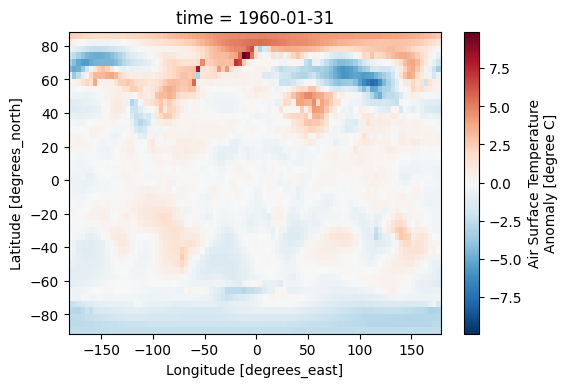

In [ ]:
!pip install wget
import wget

if(IN_COLAB):
    # !wget https://github.com/eabarnes1010/ats655-coursematerial/raw/master/jupyter_notebooks/data/BEST-1950-2018-monthlyTemp.nc
    filename = wget.download('https://eabarnes-data.atmos.colostate.edu/course_objective_analysis/BEST-1950-2018-monthlyTemp.nc')    
    ds = xr.open_dataset(filename) # open the data
else:    
    ds = xr.open_dataset('../data/BEST-1950-2018-monthlyTemp.nc') # open the data

ds = ds.sel(time = slice('1960-01-01', '2020-01-01')) # only grab certain years
ds = ds[{'latitude': slice(None, None, 4), 'longitude': slice(None, None, 4)}] # downsample to make easier to manage
ds = ds.fillna(0.) # fill Nans with 0 for a zero anomaly
print(ds)

ds['temperature'][0].plot()

### Calculate the EOFs

In [ ]:
# get data into a 2D matrix
X = ds['temperature'].values
X = X.reshape(X.shape[0],X.shape[1]*X.shape[2])
X.shape

(708, 4050)

In [ ]:
# calculate the covariance matrix in the spatial dimension
C = 1./np.size(X,axis = 0)*(np.dot(np.transpose(X),X))

# calculate eigenvalues and eigenvectors of C
lam, E = LA.eig(C)
Z = np.dot(X,E)

# convert eigenvalues to percent variance explained
pve = 100.*lam/np.sum(lam)


## Plotting functions

### Plot the results: eigenvalues

In [ ]:
def plot_eigenvalues():
  # plot results: EIGENVALUES
  plt.figure()
  plt.plot(np.arange(1,np.size(pve)+1.),pve,'o-',linewidth = 1, color = 'black', markersize = 4)

  plt.plot([np.max(eof_number)+1.5,np.max(eof_number)+1.5],[0,20],'--k')
  plt.title('Variance Retained = ' + str(np.round(np.sum(pve[eof_number]))) + '%')
  plt.xlim(-0.5, np.max([60.,eof_number[-1]+1.5]))
  plt.ylim(0,np.max(pve)*1.02)
  plt.xlabel('eigenvalue position')
  plt.ylabel('percent variance explained (%)')

  # plot error bars according to North et al.abs
  # here we will assume that all of the data is independent (is that a good assumption?)
  # such that Nstar = N
  Nstar = np.size(X,axis = 1)
  eb = pve*np.sqrt(2./Nstar)
  plt.errorbar(np.arange(1,np.size(pve)+1.),pve,yerr = eb/2, xerr = None, linewidth = 1, color = 'black')

  plt.show()

### Plot the results: compare the raw map and the smoothed map

In [ ]:
def plot_reconstructed_maps():
  # plot the output
  maxVal = 3.

  titleSize = 10
  cmap = cmocean.cm.balance
  fastBool = True
  lats = ds['latitude']
  lons = ds['longitude']

  plt.figure(figsize=(15,4.5))

  ax = plt.subplot(1,2,1,projection=mapProj)
  xplot = X.reshape(X.shape[0],len(lats),len(lons))[month_to_plot,:,:]
  cb, image = drawOnGlobe(ax, xplot, lats, lons, cmap=cmap, vmin = -maxVal, vmax=maxVal, cbarBool=True, fastBool=fastBool)
  cb.set_label('', fontsize=titleSize)
  cb.ax.tick_params(labelsize=titleSize) 
  plt.title('Month = ' + str(month_to_plot) + '\nRaw Data', fontsize=titleSize)


  ax = plt.subplot(1,2,2,projection=mapProj)
  xplot = Xrecon.reshape(Xrecon.shape[0],len(lats),len(lons))[month_to_plot,:,:]
  if(np.max(xplot.flatten())<1.):
      maxVal = np.max(xplot.flatten())
  cb, image = drawOnGlobe(ax, xplot, lats, lons, cmap=cmap, vmin = -maxVal, vmax=maxVal, cbarBool=True, fastBool=fastBool)
  cb.set_label('', fontsize=titleSize)
  cb.ax.tick_params(labelsize=titleSize) 
  plt.title('Month = ' + str(month_to_plot) + '\nsmoothed by retaining ' + str(eof_number[-1]+1) + ' of ' + str(len(pve)) + ' EOFs' +
            '\nvariance explained = ' + str(np.round(np.sum(pve[eof_number]))) + '%', fontsize=titleSize)


  plt.tight_layout()
  plt.show()

# User input

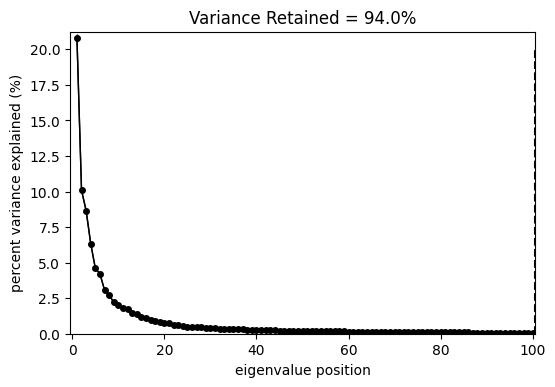

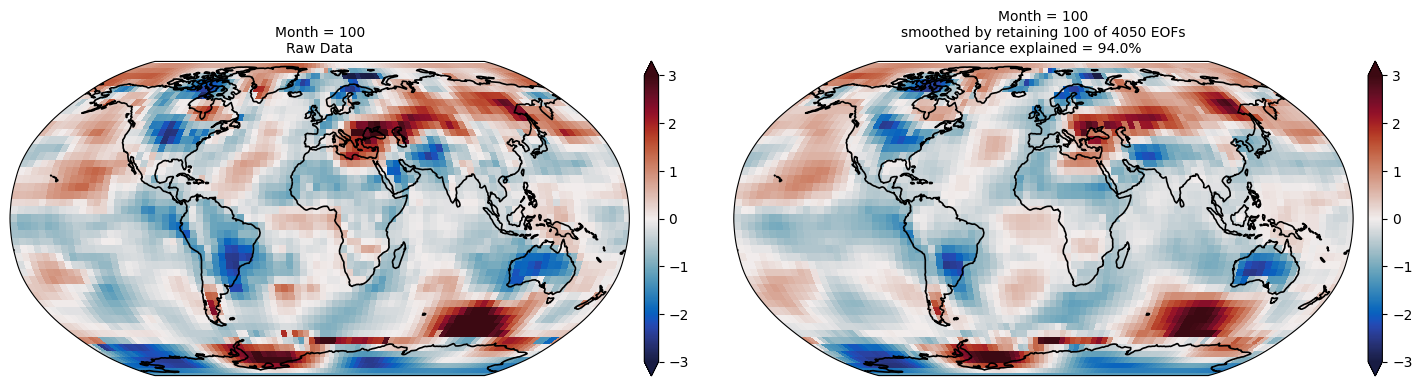

In [ ]:
#========== MODIFY =============
eof_number = np.arange(0,100) #how many EOFs to retain, maximum = 4050 
month_to_plot = 100
#===============================

plot_eigenvalues()

#---------------------------
# reduce E and Z to the number of eofs you want to retain,
# then reconstruct X

# retain only certain eofs
Zrecon = np.copy(Z[:,eof_number])
Erecon = np.copy(E[:,eof_number])
# reconstruct X
Xrecon = np.dot(Zrecon,np.transpose(Erecon))
#---------------------------

plot_reconstructed_maps()
